# Notebook Processo Seletivo Aluno Especial IA-024 1S2024 FEEC-UNICAMP
versão 5 de fevereiro de 2024, 19h

In [1]:
!pip install torchtext
!pip install 'portalocker>=2.0.0'

ERROR: Invalid requirement: "'portalocker"


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import get_tokenizer

In [3]:
# Parâmetros gerais de execução do Notebook
# Uso do Tokenizador
use_tokenizer = True

# Preloading data
preload_to_gpu = True

# Learning Rate
best_LR = 0.5

# Shuffle Dataloader (treinamento)
train_shuffle = True

# Número de amostras usadas
n_samples = 25000 

# Balanceamento do dataset 
balance_dataset = False


## I - Vocabulário e Tokenização

In [4]:
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

# I.1. Na célula de calcular o vocabulário, aproveite o laço sobre IMDB de treinamento e utilize um segundo contador
# para calcular o número de amostras positivas e amostras negativas.
# Calcule também o comprimento médio do texto em número de palavras dos textos das amostras.

counter = Counter()
counter_lbl = Counter({"pos": 0, "neg": 0, "total": 0})
total_review_len = 0
avg_review_len = 0

for (label, line) in list(IMDB(split='train'))[:n_samples]:
    if (use_tokenizer):
      tokenizer = get_tokenizer('basic_english')
      # tokenize the sentence
      line = tokenizer(line)
      counter.update(line)
    else:
      counter.update(line.split())

    # Número de amostras positivas e negativas
    if (label == 1):
      counter_lbl['neg'] += 1
    else:
      counter_lbl['pos'] += 1
    counter_lbl['total'] += 1

    if (use_tokenizer):
      total_review_len += len(line)
    else:
      total_review_len += len(line.split())

# Comprimento médio
avg_review_len = total_review_len / counter_lbl['total']

# I.2 Mostre as cinco palavras mais frequentes do vocabulário e as cinco palavras menos frequentes.
# Qual é o código do token que está sendo utilizado quando a palavra não está no vocabulário?
# Calcule quantos tokens das frases do conjunto de treinamento que não estão no vocabulário.

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab) #Errata

print("Amostras positivas, negativas e totais:")
print(counter_lbl)
print()

print("Comprimento médio do texto em palavras")
print(avg_review_len)
print()

print("Cinco palavras mais frequentes:")
print(most_frequent_words[:5])
print()

print("Cinco palavras menos frequentes:")
print(most_frequent_words[-5:])
print()

Amostras positivas, negativas e totais:
Counter({'total': 25000, 'pos': 12500, 'neg': 12500})

Comprimento médio do texto em palavras
270.68748

Cinco palavras mais frequentes:
['the', '.', ',', 'and', 'a']

Cinco palavras menos frequentes:
['voicing', 'hazard', 'lynda', 'gft', 'watergate']



In [5]:
# I.2 Calcule quantos tokens das frases do conjunto de treinamento que não estão no vocabulário.

def encode_sentence(sentence, vocab, use_tokenizer):
    if (use_tokenizer):
       sentence = tokenizer(sentence)
       return [vocab.get(word, 0) for word in sentence]
    else:
      return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza", vocab, use_tokenizer)

# Cálculo do número de tokens que não estão no vocabulário na base de treinamento:
tokens = []
for (label, line) in list(IMDB(split='train'))[:n_samples]:
  tokens.extend(encode_sentence(line, vocab, use_tokenizer))

print("Número de tokens que não estão no vocabulário na base de treinamento:")
print(tokens.count(0))

Número de tokens que não estão no vocabulário na base de treinamento:
174226


#### I.2 Qual é o código do token que está sendo utilizado quando a palavra não está no vocabulário?

Na função de dicionário dict.get() o segundo parâmetro indica o valor default caso a palavra não seja encontrada no dicionário. Nesse caso o código do token usado é o número zero.


#### I.3.a) Qual é a razão pela qual o modelo preditivo conseguiu acertar 100% das amostras de teste do dataset selecionado com apenas as primeiras 200 amostras?

Ao reduzirmos a base de treinamento para apenas 200 amostras, a base se tornou totalmente desbalanceada. Como pudemos verificar, temos 200 amostras classificadas como negativas e nenhuma como positiva.
Portanto a taxa de acurácia calculada sobre a classificação da base de testes depende unicamente da percentagem de amostras positivas ou negativas nesta base.

#### I.3.b) Modifique a forma de selecionar 200 amostras do dataset, porém garantindo que ele continue balanceado, isto é, aproximadamente 100 amostras positivas e 100 amostras negativas.

Para obtermos um dataset balanceado, usaremos uma função que seleciona amostras do dataset de acordo com a classificação e cria um dataset com a quantidade de amostras de cada classificação desejada conforme abaixo.

In [6]:
# Função para selecionar dados balanceados
from random import shuffle

def balanced_dataset(data, size):
  if (balance_dataset):
    data_pos = [(label,line) for label, line in data if label == 2][:int(size/2)]
    data_neg = [(label,line) for label, line in data if label == 1][:int(size/2)]

    data_bal = data_pos + data_neg
    shuffle(data_bal)

    return data_bal
  else:
     return data

# Aplicando sobre a base de treinamento

train_data = IMDB(split='train')
counter = Counter()
total_review_len = 0
avg_review_len = 0

for (label, line) in list(balanced_dataset(train_data, n_samples)):
    counter.update(line.split())

    # Comprimento médio do texto das reviews em palavras
    tokenizer = get_tokenizer('basic_english')

    # tokenize the sentence
    tokens = tokenizer(line)

    # count the number of words
    total_review_len += len(tokens)

# Comprimento médio
avg_review_len = total_review_len / n_samples

print("Comprimento médio do texto em palavras na base balanceada")
print(avg_review_len)
print()

Comprimento médio do texto em palavras na base balanceada
270.68748



## II - Dataset

In [7]:
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        
        # II.2.b) Trecho que precisa ser otimizado. (Esse é um problema mais difícil)
        self.data = list(balanced_dataset(IMDB(split='train'), n_samples))

        if preload_to_gpu:          
          labels = [x[0] for x in self.data]
          lines = [x[1] for x in self.data]

          # One-Hot Encoding
          self.labels_enc = []
          for l in labels:
            l = 1 if l == 1 else 0
            self.labels_enc.append(l)
          self.labels_enc = torch.tensor(self.labels_enc)
          self.labels_enc = self.labels_enc.to(device)

          self.lines_enc = []
          for l in lines:
            X = torch.zeros(len(vocab) + 1)

            for word in encode_sentence(l, vocab, use_tokenizer):
              X[word] = 1
            self.lines_enc.append(X)
          self.lines_enc = [tensor.to(device) for tensor in self.lines_enc]

        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if not preload_to_gpu:
          label, line = self.data[idx]
          label = 1 if label == 1 else 0

          # one-hot encoding
          X = torch.zeros(len(self.vocab) + 1)
              
          for word in encode_sentence(line, self.vocab, use_tokenizer):
              X[word] = 1

          return X, torch.tensor(label)
        else:
          return self.lines_enc[idx], self.labels_enc[idx]

In [8]:
# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)

# II.1.a) Investigue o dataset criado na linha 24. Faça um código que aplique um laço sobre o dataset train_data
# e calcule novamente quantas amostras positivas e negativas do dataset.
# II.1.b) Calcule também o número médio de palavras codificadas em cada vetor one-hot.
# Compare este valor com o comprimento médio de cada texto (contado em palavras), conforme calculado no exercício

counter_lbl = Counter({"pos": 0, "neg": 0, "total": 0})
words_encoded = 0
for (oneHot, sentiment) in train_data:

    words = oneHot.tolist()
    label = sentiment.item()

    # Número de amostras positivas e negativas
    if (label == 1):
      counter_lbl['neg'] += 1
    else:
      counter_lbl['pos'] += 1
    counter_lbl['total'] += 1

    hot_encoded = sum(words[i] for i in range(len(words)) if words[i] != 0)
    words_encoded +=  hot_encoded

avg_words_enc = words_encoded / counter_lbl['total']

print("Amostras positivas, negativas e totais:")
print(counter_lbl)
print()

print("Quantidade média de palavras codificadas em cada vetor one-hot")
print(avg_words_enc)
print()

Amostras positivas, negativas e totais:
Counter({'total': 25000, 'pos': 12500, 'neg': 12500})

Quantidade média de palavras codificadas em cada vetor one-hot
139.59268



#### II.1.b Compare este valor com o comprimento médio de cada texto (contado em palavras), conforme calculado no exercício I.1.c. e explique a diferença.

No exercício I.1.c, o comprimento médio do texto em palavras depois de passar pelo tokenizador foi de cerca de 270 palavras. Essa diferença do vetor One-Hot se deve ao fato que o vetor one-hot só codifica as palavras que foram identificadas no dicionário, enquanto que o comprimento médio considera todas as palavras das sentenças. Ou seja, palavras que não foram codificadas no dicionário serão representadas por zeros.

## III - Data Loader

In [9]:
batch_size = 128
# define dataloaders

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=train_shuffle)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## IV - Modelo

In [10]:
class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()
        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)

# Model instantiation
model = OneHotMLP(vocab_size)

## V - Laço de Treinamento - Otimização da função de Perda pelo Gradiente descendente

In [11]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: NVIDIA GeForce RTX 2060


In [12]:
# II.2 Com a o notebook configurado para GPU T4, meça o tempo de dois laços dentro do
# for da linha 13 (coloque um break após dois laços) e determine quanto demora
# demora para o passo de forward (linhas 14 a 18), para o backward (linhas 20, 21 e 22)
# e o tempo total de um laço. Faça as contas e identifique o trecho que é mais demorado.
# II.2.a) Tempo do laço = ; Tempo do forward = ;Tempo do backward = ; Conclusão.

import time

# Transformando em função o treinamento
def train_mdl(model, lr):
  # Debug
  print_loop = False

  model = model.to(device)
  # Define loss and optimizer
  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.SGD(model.parameters(), lr)

  # Training loop
  num_epochs = 5

  for epoch in range(num_epochs):
      start_time = time.time()  # Start time of the epoch
      model.train()

      loop_count = 0

      for inputs, labels in train_loader:
          loop_start = time.time()
          if(loop_count == 2 and print_loop):
            # Para medição do tempo do loop.
            break

          forward_start = time.time()
          
          if not preload_to_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)
          
          gpu_cpy_time = time.time() - forward_start
          # Forward pass
          model_start = time.time()
          outputs = model(inputs)
          model_time = time.time() - model_start
          loss = criterion(outputs.squeeze(), labels.float())
          forward_time = time.time() - forward_start

          # Backward and optimize
          backward_start = time.time()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          backward_time = time.time() - backward_start

          # Loop optimization
          loop_count += 1
          loop_time = time.time() - loop_start
          if (epoch == 0 and print_loop):
            print("Loop #", loop_count)
            print("Tempo de loop = ", loop_time)
            print("Forward pass = ", forward_time)
            gpu_percent = gpu_cpy_time/forward_time
            print("Gpu copy = " + str(gpu_percent*100) + " %")
            print("Model processing = " + str((1 - gpu_percent)*100) + " %")
            print("Backward pass = ", backward_time)
            print()

      end_time = time.time()  # End time of the epoch
      epoch_duration = end_time - start_time  # Duration of epoch

      print(f'Epoch [{epoch+1}/{num_epochs}], \
              Loss: {loss.item():.4f}, \
              Elapsed Time: {epoch_duration:.2f} sec')

# Primeiro treinamento com a melhor taxa de Learning Rate 
train_mdl(model, best_LR)

Epoch [1/5],               Loss: 0.3748,               Elapsed Time: 4.23 sec
Epoch [2/5],               Loss: 0.4524,               Elapsed Time: 0.57 sec
Epoch [3/5],               Loss: 0.3885,               Elapsed Time: 0.56 sec
Epoch [4/5],               Loss: 0.2724,               Elapsed Time: 0.55 sec
Epoch [5/5],               Loss: 0.1962,               Elapsed Time: 0.57 sec


##### II.2.a) Medição dos tempos de loop

Notamos que o tempo do passo do forward leva mais tempo que o passo de backward, conforme os dados obtidos abaixo para a primeira época do treinamento.
Também notamos que a maior parte to tempo do loop de forward é gasto com a transferência dos dados da CPU para a GPU (97% no primeiro loop).

**Para 200 amostras**:

```
Loop # 1
Tempo de loop =  0.048320770263671875
Forward pass =  0.047322750091552734
Gpu copy = 97.88851606662435 %
Model processing = 2.1114839333756574 %
Backward pass =  0.0009980201721191406

Loop # 2
Tempo de loop =  0.007141590118408203
Forward pass =  0.005140781402587891
Gpu copy = 80.50737408403673 %
Model processing = 19.49262591596327 %
Backward pass =  0.0020008087158203125
```
##### II.2.b) Trecho que precisa ser otimizado. (Esse é um problema mais difícil)

Para otimizarmos o loop, o carregamento dos dados em GPU pode ser realizado pelo Dataloader fora do loop de treinamento, para tanto alterando o método __init__() da classe IMDBDataset.
```
def __init__(self, split, vocab):
    #self.data = list(IMDB(split=split))[:n_samples]
    self.data = list(balanced_dataset(IMDB(split=split), n_samples))        
    self.vocab = vocab
```
##### II.2.c) Otimize o código e explique aqui.
Substituimos então com a nova implementação, onde o dataset inteiro é pré-processado, codificado em forma One-Hot (uma vez que tensores não suportam strings) e movido para a GPU antes do processo de treinamento:
````
def __init__(self, split, vocab):
    
    # II.2.b) Trecho que precisa ser otimizado. (Esse é um problema mais difícil)
    self.data = list(balanced_dataset(IMDB(split='train'), n_samples))

    if preload_to_gpu:          
        labels = [x[0] for x in self.data]
        lines = [x[1] for x in self.data]

        # One-Hot Encoding
        self.labels_enc = []
        for l in labels:
        l = 1 if l == 1 else 0
        self.labels_enc.append(l)
        self.labels_enc = torch.tensor(self.labels_enc)
        self.labels_enc = self.labels_enc.to(device)

        self.lines_enc = []
        for l in lines:
        X = torch.zeros(len(vocab) + 1)
        for word in encode_sentence(l, vocab):
            X[word] = 1
        self.lines_enc.append(X)
        self.lines_enc = [tensor.to(device) for tensor in self.lines_enc]

    self.vocab = vocab
````
##### Comparação do tempo de treinamento com a otimização (GPU RTX2060 local):
Sem pre-load em GPU:
````
Epoch [1/5],             Loss: 0.6911,             Elapsed Time: 61.36 sec
Epoch [2/5],             Loss: 0.6929,             Elapsed Time: 58.69 sec
Epoch [3/5],             Loss: 0.6984,             Elapsed Time: 58.95 sec
Epoch [4/5],             Loss: 0.6792,             Elapsed Time: 58.60 sec
Epoch [5/5],             Loss: 0.6874,             Elapsed Time: 58.59 sec
````
Com pre-load em GPU (RTX2060)
````
Epoch [1/5],             Loss: 0.6896,             Elapsed Time: 3.81 sec
Epoch [2/5],             Loss: 0.6925,             Elapsed Time: 0.58 sec
Epoch [3/5],             Loss: 0.6933,             Elapsed Time: 0.64 sec
Epoch [4/5],             Loss: 0.6890,             Elapsed Time: 0.58 sec
Epoch [5/5],             Loss: 0.6904,             Elapsed Time: 0.57 sec
````
Notamos, no entanto, que o uso de mémória na GPU se torna muito maior, conforme pode ser visualizado abaixo (5Gb/6Gb total):
````
[venv:ml] $ nvidia-smi
Mon Feb 12 08:23:42 2024
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   76C    P8    12W /  N/A |   5035MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
````

## VI - Avaliação

In [13]:
## evaluation
def eval_mdl(model):
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100* correct/total
        print(f'Test Accuracy: {acc}%')
    return acc

eval_mdl(model)

Test Accuracy: 92.732%


92.732

##### II.3 Faça a melhor escolha do LR, analisando o valor da acurácia no conjunto de teste, utilizando para cada valor de LR, a acurácia obtida. Faça um gráfico de Acurácia vs LR e escolha o LR que forneça a maior acurácia possível.

In [14]:
lr_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
acc_list = []

for lr in lr_list:
    print("LR = ", lr)
    model = OneHotMLP(vocab_size) # to reset weights 
    train_mdl(model, lr)
    acc_list.append(eval_mdl(model))
    print()

print(lr_list)
print(acc_list)
print()

LR =  0.0001
Epoch [1/5],               Loss: 0.6944,               Elapsed Time: 0.56 sec
Epoch [2/5],               Loss: 0.6926,               Elapsed Time: 0.56 sec
Epoch [3/5],               Loss: 0.6920,               Elapsed Time: 0.57 sec
Epoch [4/5],               Loss: 0.6989,               Elapsed Time: 0.55 sec
Epoch [5/5],               Loss: 0.6949,               Elapsed Time: 0.57 sec
Test Accuracy: 50.04%

LR =  0.001
Epoch [1/5],               Loss: 0.6935,               Elapsed Time: 0.57 sec
Epoch [2/5],               Loss: 0.6908,               Elapsed Time: 0.56 sec
Epoch [3/5],               Loss: 0.6847,               Elapsed Time: 0.55 sec
Epoch [4/5],               Loss: 0.6868,               Elapsed Time: 0.56 sec
Epoch [5/5],               Loss: 0.6809,               Elapsed Time: 0.55 sec
Test Accuracy: 69.52%

LR =  0.01
Epoch [1/5],               Loss: 0.6780,               Elapsed Time: 0.56 sec
Epoch [2/5],               Loss: 0.6182,               Elaps

##### II.3.a) Gráfico Acurácia vs LR

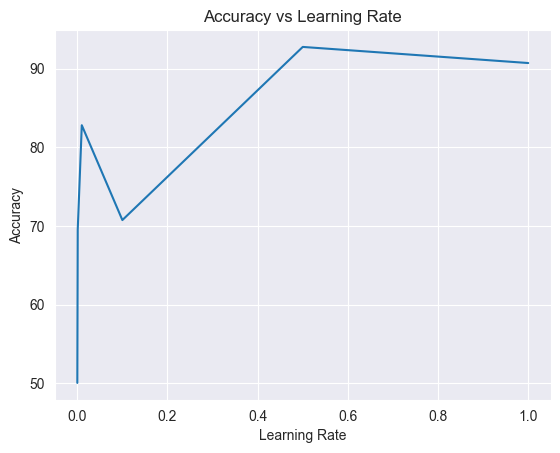

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.lineplot(x=lr_list, y=acc_list)

# Add labels and title
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning Rate")

# Show the plot
plt.show()

##### II.3.b) Valor ótimo do LR

Notamos que o valor ótimo para a Learning Rate foi de cerca de 0.5, com crescimento exponencial ao aumentá-la. Valores acima deste são grandes demais e não levam à otimização do modelo.

##### II.3.c) Mostre a equação utilizada no gradiente descendente e qual é o papel do LR no ajuste dos parâmetros (weights) do modelo da rede neural.

No processo de otimização de uma função, a fórmula utilizada para a estimativa do próximo valor da função é dada por:

````
valor atualizado = valor anterior - learning rate*gradiente
`````

Portanto o papel da LR é definir qual é o *tamanho* do passo a ser utilizado no processo de atualização.

##### II.4 Melhores a forma de tokenizar, isto é, pré-processar o dataset de modo que a codificação seja indiferente das palavras serem escritas com maiúsculas ou minúsculas e sejam pouco influenciadas pelas pontuações.
##### II.4.a) Mostre os trechos modificados para este novo tokenizador, tanto na seção I - Vocabulário, como na seção II - Dataset.

Na seção I - Vocabulário:

````
from torchtext.data import get_tokenizer

for (label, line) in list(IMDB(split='train'))[:n_samples]:
    if (use_tokenizer):
      tokenizer = get_tokenizer('basic_english')
      # tokenize the sentence
      line = tokenizer(line)
    counter.update(line.split())

    # Número de amostras positivas e negativas
    if (label == 1):
      counter_lbl['neg'] += 1
    else:
      counter_lbl['pos'] += 1
    counter_lbl['total'] += 1

    # Comprimento médio do texto das reviews em palavras
    tokenizer = get_tokenizer('basic_english')

    # tokenize the sentence
    tokens = tokenizer(line)

    # count the number of words
    total_review_len += len(tokens)

````

Na Seção II - Dataset:
São apenas necessárias alterações no encoder da sentença, conforme abaixo.

````
def encode_sentence(sentence, vocab, use_tokenizer):
    if (use_tokenizer):
       sentence = tokenizer(sentence)
       return [vocab.get(word, 0) for word in sentence]
    else:
      return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV
````


##### II.4.b) Recalcule novamente os valores do exercício I.2.c - número de tokens unknown, e apresente uma tabela comparando os novos valores com os valores obtidos com o tokenizador original e justifique os resultados obtidos.

Sem o tokenizador:

566141

Com o tokenizador:

174226

Estes valores se justificam pelo fato que o tokenizador altera as palavras das sentenças, mantendo apenas radicais, de forma que menos palavras não serão encontradas na base do vocabulário.


##### II.4.c) Execute agora no notebook inteiro com o novo tokenizador e veja o novo valor da acurácia obtido com a melhoria do tokenizador.

Sem o tokenizador:

Test Accuracy: 60.39% (Para LR = 0.5)

Com o tokenizador 

Test Accuracy: 92.74% (Para LR = 0.5)

O aumento da acurácia é justificado pelo fato que menos palavras de cada sentença não serão reconhecidas (OneHot encoding não terá tantos valores zerados)

##### Os dados obtidos estão resumidos na tabela abaixo.

In [18]:
from tabulate import tabulate

# Sample data
data = [
    ['Sem Tokenizador', 566141, '60.39%'],
    ['Com Tokenizador', 174226, '92.74%'],
]

# Headers
headers = ['Uso do Tokenizador', 'Tokens Unknown', 'Test Accuracy']

# Print the table
print(tabulate(data, headers=headers))

Uso do Tokenizador      Tokens Unknown  Test Accuracy
--------------------  ----------------  ---------------
Sem Tokenizador                 566141  60.39%
Com Tokenizador                 174226  92.74%


##### Seção III

##### Vamos estudar agora o Data Loader da seção III do notebook. Em primeiro lugar anote a acurácia do notebook com as melhorias de eficiência de rodar em GPU, com ajustes de LR e do tokenizador. Em seguida mude o parâmetro shuffle na construção do objeto train_loader para False e execute novamente o notebook por completo e meça novamente a acurácia.

In [19]:
from tabulate import tabulate

# Sample data
data = [
    ['Com Shuffle', '92.74%'],
    ['Sem Shuffle', 'x']
]

# Headers
headers = ['Shuffle dos dados de Treinamento', 'Test Accuracy']

# Print the table
print(tabulate(data, headers=headers))

Shuffle dos dados de Treinamento    Test Accuracy
----------------------------------  ---------------
Com Shuffle                         92.74%
Sem Shuffle                         x
